In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import matplotlib.collections
from scipy.interpolate import interp1d
sns.set()
from results import load
from matplotlib.lines import Line2D

from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib import colorbar
from functions import *
#constants
experiment_phase = {'p0':60000, 'p1':60000, 'p2':180000}
experiment_phase_labels = [*experiment_phase]

#avoid Font-problem in plots for ACM/IEEE papers
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# Reading the results

In [23]:
#config
experiment_name = "acr"
all = None

all_new = load("acr", ["aws","gcf","ibm","azure"],["0,0,1","0,0,0.5","60,60,1","60,60,0.5","60,60,0"],3,True)
all_old = load("full", ["aws","gcf","ibm","azure"],["0,0,1","0,0,0.5","60,60,1","60,60,0.5","60,60,0"],2,True)
all_new_maf = load("low", ["azure"],["0,0,1","5,5,0","15,15,0","60,60,0"],2,True)

all = pd.concat([all_new,all_old,all_new_maf],ignore_index=True)
#this is important for phase based plots (leave it otherwise)
all = all[(all["Phase"] != "none")]
providers = all["Provider"].unique()
num_repetitions = 3
configs = all["WL"].unique()

print(configs,providers,all["Experiment"].unique())
all.columns

['0,0,1' '0,0,0.5' '60,60,1' '60,60,0.5' '60,60,0' '5,5,0' '15,15,0'] ['azure' 'gcf' 'aws' 'ibm'] ['acr' 'full' 'low']


Index(['RId', 'CIdOld', 'WL', 'CId', 'CStart', 'ECost', 'DLat', 'ELat',
       'RFailed', 'Phase', 'RStart', 'EStart', 'EEnd', 'REnd', 'CNew', 'CPlat',
       'TLat', 'COs', 'RInput', 'Provider', 'Region', 'RLat', 'BLat',
       'RResult', 'run', 'sourceFile', 'RCode', 'RSuccessed', 'HIdOld', 'HId',
       'Experiment', 'FOpt', 'PlatfromName', 'FEnv'],
      dtype='object')

In [24]:
all_new[all_new["Provider"]=="gcf"].groupby(["WL","run"])["RId"].count()

WL         run
0,0,0.5    1.0     6390
           2.0     6370
0,0,1      1.0    12654
           2.0    12743
           3.0    12730
60,60,0    1.0    18155
           2.0    18118
60,60,0.5  1.0    24514
           2.0    24543
60,60,1    1.0    30882
           2.0    30870
Name: RId, dtype: int64

### Styles and Constants

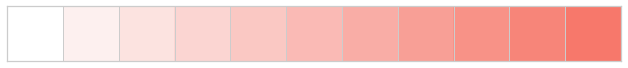

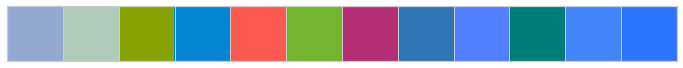

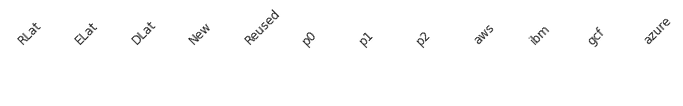

In [250]:
#sns.set_palette(sns.color_palette("Paired"))

palette = sns.color_palette().as_hex()
style = {
    "aws":{
        "name":"AWS",
        "color":"#527fff"#palette[8]
    },
    "ibm":{
        "name":"ICF",
        "color":"#007d79"#palette[1]
    },
    "gcf":{
        "name":"GCF",
        "color":"#4485f9"#palette[2]
    },
    "azure":{
        "name":"MAF",
        "color":"#2d75fe" ##fec21f palette[4]
    },
    "CNew":{
        "New":"#0485d1",
        "Cold":"#0485d1",
        "Reused": "#fc5a50",
        "Warm": "#fc5a50"
    },
    #colors
    "Lats":{
        "Delivery Latency":"#d1ffbd",
        "Request-Response Latency":"#92a8d1",
        "Execution Latency":"#B1cbbb",
        "Backward Response Delivery Latency":"#89a203",
        "Delivery":"#89a203",
        "Delivery Latency":"#89a203",
        "Request-Response":"#92a8d1",
        "Execution":"#B1cbbb",
        "Backward Response Delivery":"#89a203",
        "DLat":"#89a203",
        "BLat":"#89a203",
        "RLat":"#92a8d1",
        "ELat":"#B1cbbb",
        "Failiur":"#DC1E1E"
    },
    "Phases":{
        "p0":"#74B52F",
        "p2":"#2F74B5",
        "p1":"#B52F74",
        "warmup":"#74B52F",
        "cooldown":"#2F74B5",
        "scaling":"#B52F74"
    },
    #Strings
    "Names":{
        "DLat":"Delivery Latency",
        "RLat":"Request-Response Latency",
        "ELat":"Execution Latency",
        "BLat":"Backward Response Delivery Latency",
        "p0":"warmup",
        "p1":"scaling",
        "p2":"cooldown",
        "HId":"VM",
        "CId":"Container",
        "HIdOld":"VM (old method)",
        "full":"Original",
        "acr":"Reproduction",
        "low":"Reproduction",
        "WL":"Workload",
        "Provider":"Provider",
        "Phase":"Phase",
        "run":"Iteration",
    },
    "Workloads":{
        '0,0,1':"WL1",
        '0,0,0.5':"WL0",
        '60,60,1':"WL4",
        '60,60,0.5':"WL3",
        '60,60,0':"WL5",
        '5,5,0':"WL6",
        '15,15,0':"WL7",
        '0,0,2':"WL2"
    }
    
}

hmcmp = [(1,1,1,1),(0.996,0.945,0.941,1),(0.992,0.894,0.882,1),(0.988,0.839,0.824,1),(0.984,0.788,0.765,1),(0.984,0.733,0.710,1),(0.980,0.682,0.651,1),(0.976,0.627,0.592,1),(0.973,0.576,0.533,1),(0.969,0.522,0.475,1),(0.969,0.471,0.42,1),]

sns.set(style="whitegrid")
plotStyle(style,hmcmp)

# Masterplot V4

In [26]:
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.gridspec import GridSpec
all_280 = all[all["EStart"].isna() | all["EStart"] < 280000 ]
all_280 = all_280[all_280["run"]==1]
#Latency Limits
default = [0,30]
ylims = {
    "aws":
    {"0,0,0.5":[0,3],"0,0,1":[0,6],"60,60,0.5":[0,6],"60,60,1":[0,6],"60,60,0":[0,6]},
    "ibm":
    {"0,0,0.5":default,"0,0,1":default,"60,60,0.5":default,"60,60,1":default,"60,60,0":default},
    "azure":
    {"0,0,0.5":default,"0,0,1":[0,40],"60,60,0.5":default,"60,60,1":default,"60,60,0":default,"5,5,0":default,"15,15,0":default},
    "gcf":
    {"0,0,0.5":default,"0,0,1":default,"60,60,0.5":default,"60,60,1":default,"60,60,0":default},
    "workload":
    {"0,0,0.5":[0,120],"0,0,1":[0,120],"60,60,0.5":[0,120],"60,60,1":[0,120],"60,60,0":[0,120],"5,5,0":[0,120],"15,15,0":[0,120]},
}
#Heatmap obergrenze
vmax=15
#Heatmap VM-cutoff (VMs mit weniger als x [%] auslastung  ) Reduziert verticale dichte und rechenzeit
cutoff=0.1

In [248]:
def diffPlot(data_280,workload,provider,fname,experiment=("acr","full")):       
    #setup figure
    fig = plt.figure(figsize=(11,11))
    gs = fig.add_gridspec(ncols=1, nrows=2,hspace=0.20)
    xlim=[0,280]    
   
    
    exp = experiment[0]
    data = all_280[all_280["Experiment"]==exp]
    ax = fig.add_subplot(gs[1])
    plotClientSideOverview(ax,data,provider,workload,style=style,ylim=ylims[provider][workload],
                           xlim=xlim,with_thruput=True,legend=False,
                           title="{}".format(style["Names"][exp]))
    ax.set_ylim(ylims["workload"][workload])
    
    exp = experiment[1]
    data = all_280[all_280["Experiment"]==exp]
    ax = fig.add_subplot(gs[0])
    plotClientSideOverview(ax,data,provider,workload,style=style,ylim=ylims[provider][workload],
                           xlim=xlim,with_thruput=True,legend=False,
                           title="{}".format(style["Names"][exp]))
    #fix y-axis
    ax.set_ylim(ylims["workload"][workload])
    
    #create legend by hand
    legendShapes = [
                    Line2D([0], [0], color="gray", lw=2),
                    Line2D([0], [0], marker='.',color=style[provider]["color"], lw=0, markersize=10),
                    Line2D([0], [0], marker='+', lw=0,color='indianred',markerfacecolor='indianred', markersize=10),
                    Line2D([0], [0], color=style["Lats"]["RLat"], lw=4),
                    Line2D([0], [0], color=style["Lats"]["ELat"], lw=4),
                ]
    legendNames = ["tsps","RSuccess","RFailed","RLat","ELat"]
    ax.legend(legendShapes, legendNames, loc='upper left',fancybox=True, shadow=True, ncol=2)
    
    if fname is not None:
        plt.savefig(fname, bbox_inches='tight')

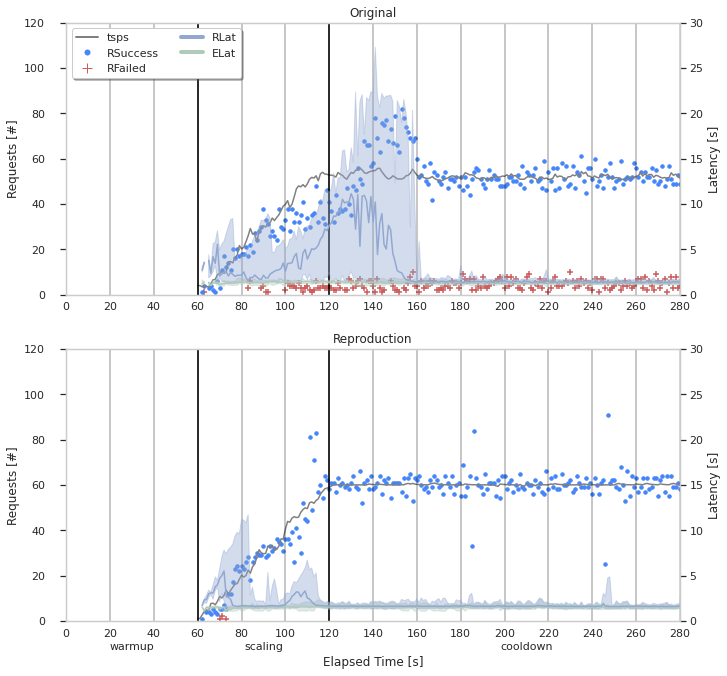

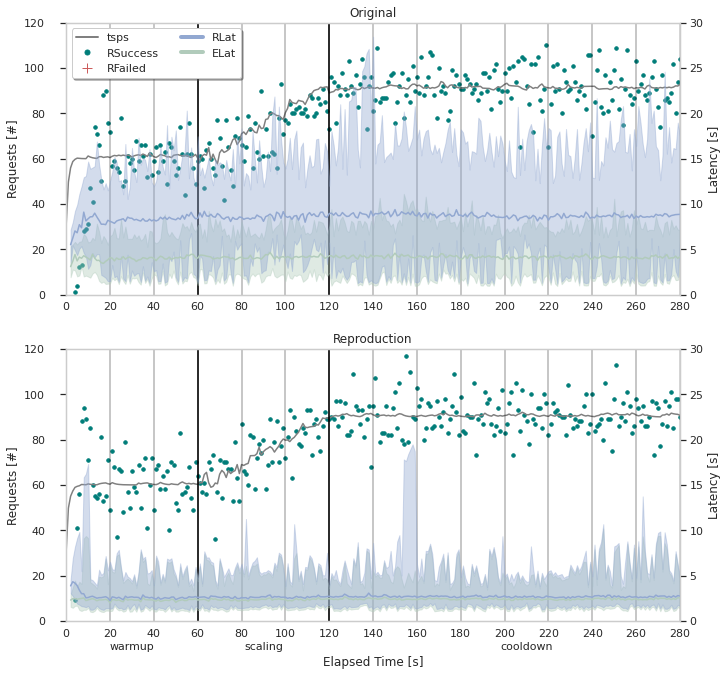

In [251]:

diffPlot(all[all["run"]==1],"0,0,1","gcf","plots/gcf.pdf",experiment=("acr","full"))
diffPlot(all,"60,60,0.5","ibm","plots/icf_60,60,0.5.pdf",experiment=("acr","full"))

## Table

In [159]:
def q(x,name):
    def _q(n):
        return np.percentile(n,x)
    _q.__name__ = name
    return _q

def count(n):
    return len(n)

def count_failed(n):
    return np.count_nonzero(n)
def percentage(n):
    return count_failed(n)/count(n)


#caution overly complicated magic function... is supposed to rename the index to the paper names ;)
#assumtion first to colums are provider and workload 
def reindex(df):
    values = df.index.values
    names = df.index.names
    new_values = []
    multidimensional = True
    for value in values:
        if type(value) is tuple:
            new_value = []
            new_value.append(style[value[0]]['name'])
            new_value.append(style["Workloads"][value[1]])
            for i in range(2,len(value)):
                new_value.append(value[i])
                
            new_values.append(tuple(new_value))
        else:
            multidimensional = False
            new_values.append(style[value]['name'])
    new_names = []
    for name in names:
        new_names.append(style["Names"][name])
        
    #print(df.index,new_values,new_names)
    if multidimensional:
        df.index=pd.MultiIndex.from_tuples(new_values,names=new_names)
    else:
        df.index=pd.Index(new_values,name=new_names[0])
    return df

count.__name__ = "Requests"
count_failed.__name__="Failed Requests"
percentage.__name__="Failed [%]"

def paperDataSet(data,providers,workloads,runs):
    data = data[data["Provider"].isin(providers)]
    data = data[data["WL"].isin(workloads)]
    data = data[data["run"].isin(runs)]
    return data

def createMetrics(data,providers,workloads,runs,group_key=["Provider","WL"],withMedian=False):
    #filter data
    data = paperDataSet(data,providers,workloads,runs)
    return metcisFromData(data,group_key,withMedian)
    
def metcisFromData(data,group_key=["Provider","WL"],withMedian=False):
    metrics = [np.mean,q(90,"p90"),q(99,"p99"),np.max]
    if withMedian:
        metrics.append(np.median)
    
    #create performance metrics
    perf = data[data["RFailed"]==False].groupby(group_key)[["RLat","ELat"]].agg(
        metrics
    )

    reliability = data.groupby(group_key)["RFailed"].agg([count,count_failed,percentage])
    
    reliability.columns = pd.MultiIndex.from_tuples([
        ('Requests','Send [\#]'),('Requests','Failed [\#]'),('Requests','Failed [\%]')
    ])
    data["ECost"] = data["ECost"]/10
    costs = data[data["RFailed"]==False].groupby(group_key)["ECost"].agg([np.mean])#,np.median])
    costs.columns = pd.MultiIndex.from_tuples([
        ('ECost [$\mu\$$]','Mean')#,('ECost [$\mu\$$]','Median'),
    ])
    
    labels = ["Mean",'90-p','99-p','Max']
    if withMedian:
        labels.append("Med")
    #python magic incoming: create a list of paired lables (latname + metric...)
    rlats = list(map(tuple,zip(["RLat"+' [s]']*len(labels),labels)))
    elats = list(map(tuple,zip(["ELat"+' [s]']*len(labels),labels)))
    #python magic over
    perf.columns = pd.MultiIndex.from_tuples(rlats+elats)
    
    
    
    reindex(perf)
    reindex(reliability)
    reindex(costs)
    
    return perf,reliability,costs

In [162]:
p_old,r_old,c_old = createMetrics(all_old,["aws","gcf","ibm"],["0,0,0.5","0,0,1","60,60,1","60,60,0.5"],[1])
p_new,r_new,c_new = createMetrics(all_new,["aws","gcf","ibm"],["0,0,0.5","0,0,1","60,60,1","60,60,0.5"],[1])

#generate diff
perf = p_old-p_new
reliability = r_old-r_new
cost = c_old-c_new
#remove Failed [%] as it makes no sense in this context
reliability = reliability.drop('Failed [\%]', axis=1, level=1)
#rename col.
reliability.columns = pd.MultiIndex.from_tuples([
        ('Requests [\#]','Send'),('Requests [\#]','Failed')
    ])

df = pd.concat([reliability,perf,cost],axis=1)
df.index = df.index.rename([""," "])

pd.options.display.float_format = "{:,.2f}".format
with open('plots/diff.tex', 'w') as f:
    f.write(df.to_latex(multicolumn_format="c",escape=False))
df

Reliablity [\#]        RLat [s]                    ELat [s]        \
                    Req Failed     Mean  90-p  99-p    Max     Mean  90-p   
                                                                            
AWS WL0             -27      0     0.01  0.00 -0.02  -0.29    -0.01 -0.02   
    WL1             -32      0     0.02  0.01 -0.14  -0.35    -0.00 -0.00   
    WL3             242      0     0.00 -0.00 -0.26  -3.54     0.00 -0.00   
    WL4             265   2642     0.00 -0.01 -0.30  -0.27     0.01  0.01   
GCF WL0             -69      0     0.35  0.91  8.32  13.08    -0.11 -0.04   
    WL1           -1662    869     1.20  6.30 11.77  15.60    -0.18 -0.11   
    WL3             246      0     0.12  0.02  5.52  10.52    -0.04 -0.01   
    WL4             273   2610    -0.14 -0.17 -0.04   0.53    -0.12 -0.09   
ICF WL0             -35      0    -0.24 -0.59 -1.13   9.69    -0.28 -0.58   
    WL1             -22      0    -0.15 -0.28 -1.74 -13.92    -0.19 -0.30   
    WL3             260      0     6.00  7.70  9.85   8.99     1.74  2.47   
    WL4             291  -2442     6.38  8.48 11.67  18.38     1.85  2.67   

                    ECost [$\mu\$$]  
         99-p   Max            Mean  
                                     
AWS WL0  0.03  0.34           -0.11  
    WL1 -0.05 -0.38            0.00  
    WL3  0.02 -0.54            0.09  
    WL4 -0.11 -0.39            0.10  
GCF WL0 -0.12  0.25           -1.81  
    WL1 -0.26 -0.54           -3.02  
    WL3  0.07 -0.10           -0.77  
    WL4 -0.21 -0.25           -1.92  
ICF WL0 -1.02 -1.04           -4.78  
    WL1 -1.61 -4.53           -3.21  
    WL3  2.57  0.61           29.59  
    WL4  3.30  5.68           31.42

In [252]:
p_old,r_old,c_old = createMetrics(all_old,["aws","gcf","ibm"],["0,0,0.5","0,0,1","60,60,1","60,60,0.5"],[1])
p_new,r_new,c_new = createMetrics(all_new,["aws","gcf","ibm"],["0,0,0.5","0,0,1","60,60,1","60,60,0.5"],[1])

#generate diff
perf = p_new-p_old
reliability = r_new-r_old
cost = c_new-c_old
#remove Failed [%] as it makes no sense in this context
reliability = reliability.drop('Failed [\%]', axis=1, level=1)
#rename col.
reliability.columns = pd.MultiIndex.from_tuples([
        ('Requests [\#]','Send'),('Requests [\#]','Failed')
    ])

df = pd.concat([reliability,perf,cost],axis=1)
df.index = df.index.rename([""," "])

pd.options.display.float_format = "{:,.2f}".format
with open('plots/diff.tex', 'w') as f:
    f.write(df.to_latex(multicolumn_format="c",escape=False))
df

Requests [\#]        RLat [s]                     ELat [s]        \
                 Send Failed     Mean  90-p   99-p    Max     Mean  90-p   
                                                                           
AWS WL0            27      0    -0.01 -0.00   0.02   0.29     0.01  0.02   
    WL1            32      0    -0.02 -0.01   0.14   0.35     0.00  0.00   
    WL3          -242      0    -0.00  0.00   0.26   3.54    -0.00  0.00   
    WL4          -265  -2642    -0.00  0.01   0.30   0.27    -0.01 -0.01   
GCF WL0            69      0    -0.35 -0.91  -8.32 -13.08     0.11  0.04   
    WL1          1662   -869    -1.20 -6.30 -11.77 -15.60     0.18  0.11   
    WL3          -246      0    -0.12 -0.02  -5.52 -10.52     0.04  0.01   
    WL4          -273  -2610     0.14  0.17   0.04  -0.53     0.12  0.09   
ICF WL0            35      0     0.24  0.59   1.13  -9.69     0.28  0.58   
    WL1            22      0     0.15  0.28   1.74  13.92     0.19  0.30   
    WL3          -260      0    -6.00 -7.70  -9.85  -8.99    -1.74 -2.47   
    WL4          -291   2442    -6.38 -8.48 -11.67 -18.38    -1.85 -2.67   

                    ECost [$\mu\$$]  
         99-p   Max            Mean  
                                     
AWS WL0 -0.03 -0.34            0.11  
    WL1  0.05  0.38           -0.00  
    WL3 -0.02  0.54           -0.09  
    WL4  0.11  0.39           -0.10  
GCF WL0  0.12 -0.25            1.81  
    WL1  0.26  0.54            3.02  
    WL3 -0.07  0.10            0.77  
    WL4  0.21  0.25            1.92  
ICF WL0  1.02  1.04            4.78  
    WL1  1.61  4.53            3.21  
    WL3 -2.57 -0.61          -29.59  
    WL4 -3.30 -5.68          -31.42

In [212]:
r_old

Reliablity                        
                    Req [\#] Failed [\#] Failed [\%]
Provider Workload                                   
AWS      WL0            6333           0        0.00
         WL1           12708           0        0.00
         WL3           24779           0        0.00
         WL4           31147        2642        0.08
GCF      WL0            6321           0        0.00
         WL1           10992         873        0.08
         WL3           24760           0        0.00
         WL4           31155        2610        0.08
ICF      WL0            6330           0        0.00
         WL1           12727           1        0.00
         WL3           24750           0        0.00
         WL4           31199          21        0.00

In [74]:
p_new,r_new = createMetrics(all_new,["aws","gcf","ibm"],["0,0,0.5","0,0,1","60,60,1","60,60,0.5"],[1],["Provider"],True)
#Failiur Global
pd.options.display.float_format = "{:,.4f}".format
pd.concat([r_new,p_new],axis=1)

Reliablity                       Request-Response Latency [s]         \
            Req [#] Failed [#] Failed [%]                         Mean   90-p   
Provider                                                                        
AWS           74519          0     0.0000                       1.7121 1.7680   
GCF           74440          4     0.0001                       1.6058 1.7580   
ICF           74512       2464     0.0331                       2.7568 3.5280   

                               Execution Latency [s]                        \
           99-p     Max    Med                  Mean   90-p   99-p     Max   
Provider                                                                     
AWS      2.1610  5.9180 1.6970                1.6381 1.6830 1.8788  2.5150   
GCF      2.5143 11.7020 1.5810                1.4471 1.5660 1.8820  2.5190   
ICF      5.7095 22.5210 2.6470                2.4320 3.1300 4.8726 10.5170   

                 
            Med  
Provider         
AWS      1.6350  
GCF      1.4610  
ICF      2.3690

In [75]:
d_new = paperDataSet(all_new,["aws","gcf","ibm"],["0,0,0.5","0,0,1","60,60,1","60,60,0.5"],[1])

d_new = d_new[d_new["Phase"].isin(["p1","p2","p3"])]
hostview = d_new.groupby(["Provider","WL","Phase"])[["HId","CId"]].agg('nunique')
reindex(hostview)

HId  CId
Provider Workload Phase          
AWS      WL0      p1      53   53
                  p2      64   64
         WL1      p1     105  105
                  p2     114  114
         WL3      p1     160  160
                  p2     211  211
         WL4      p1     214  214
                  p2     275  275
GCF      WL0      p1      43   73
                  p2      69  118
         WL1      p1      28  127
                  p2      51  163
         WL3      p1      36  230
                  p2      37  231
         WL4      p1      30  210
                  p2      78  302
ICF      WL0      p1      12  100
                  p2      13  198
         WL1      p1      23  189
                  p2      25  288
         WL3      p1      34  295
                  p2      38  484
         WL4      p1      44  384
                  p2      50  626

In [76]:
d_new = d_new[d_new["Phase"].isin(["p1","p2","p3"])]
hostview = d_new.groupby(["Provider","Phase"])[["HId","CId"]].agg(['nunique'])
#reindex(hostview)
hostview

HId     CId
               nunique nunique
Provider Phase                
aws      p1        434     434
         p2        553     553
gcf      p1        135     637
         p2        231     808
ibm      p1         44     968
         p2         50    1596

In [77]:
d_maf = paperDataSet(all_new_maf,["azure"],["5,5,0","0,0,1","15,15,0"],[1])
d_maf.loc[d_maf["RLat"] > 30,"RFailed"] = True
p_maf,r_maf = metcisFromData(d_maf)#,group_key=["Provider"])
pd.concat([r_maf,p_maf],axis=1)

Reliablity                        \
                     Req [#] Failed [#] Failed [%]   
Provider Workload                                    
MAF      WL1           12654      12534     0.9905   
         WL7            4574       1697     0.3710   
         WL6            1505         76     0.0505   

                  Request-Response Latency [s]                          \
                                          Mean    90-p    99-p     Max   
Provider Workload                                                        
MAF      WL1                           12.4576 27.8019 29.5968 29.8840   
         WL7                           14.2807 25.9802 29.4480 29.9960   
         WL6                            6.0447 11.8940 23.2934 29.6650   

                  Execution Latency [s]                          
                                   Mean    90-p    99-p     Max  
Provider Workload                                                
MAF      WL1                     7.4628 26.4618 28.9888 29.0810  
         WL7                     3.0288  3.5770  4.5389 28.7610  
         WL6                     2.9731  3.5762  4.2546  6.4750

In [78]:
d_maf = d_maf[d_maf["Phase"].isin(["p1","p2","p3"])]
d_maf.groupby(["Provider","WL","Phase"])[["HId","CIdOld"]].agg(['nunique'])

HId  CIdOld
                     nunique nunique
Provider WL    Phase                
azure    0,0,1 p1         72      72
               p2         10      10
         5,5,0 p1         19      19
               p2         22      22